### Load stuff

In [1]:
import torch
from torchvision.transforms import Normalize
from torchvision.utils import save_image
from torchvision.utils import make_grid
from gan_model import UpsampleGenerator, Discriminator
from vae_model import VAE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
latent_dimension = 100

In [4]:
re_norm = Normalize([-1, -1, -1], [2, 2, 2])

In [11]:
# load the generatorvae_out = vae_model.decoder(new_z)
gan_checkpoint = '../upsample/checkpoint_{}.pth'.format(45)
gan_model = UpsampleGenerator(latent_dimension).to(device)
checkpoint = torch.load(gan_checkpoint, map_location=device)
gan_model.load_state_dict(checkpoint['gen_model'])
gan_model.eval()

UpsampleGenerator(
  (network): Sequential(
    (0): Upsample(scale_factor=4, mode=bilinear)
    (1): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): LeakyReLU(negative_slope=0.01)
    (3): Upsample(scale_factor=2, mode=bilinear)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Upsample(scale_factor=2, mode=bilinear)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.01)
    (9): Upsample(scale_factor=2, mode=bilinear)
    (10): Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Tanh()
  )
)

In [10]:
# load VAE
vae_checkpoint = '../upsample/vae_checkpoint.pth'
vae_model = VAE(latent_dimension).to(device)
checkpoint = torch.load(vae_checkpoint, map_location=device)
vae_model.load_state_dict(checkpoint['model'])
vae_model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
  )
  (lin1): Sequential(
    (0): Linear(in_features=2048, out_features=100, bias=True)
    (1): ReLU()
  )
  (fc11): Linear(in_features=100, out_features=100, bias=True)
  (fc12): Linear(in_features=100, out_features=100, bias=True)
  (decoder): UpsampleGenerato

In [12]:
def show_grid(imgs, nrow):
    plt.figure(figsize=(20, 20))
    plt.tight_layout()
    for i, img in enumerate(imgs):
        ax = plt.subplot(1,nrow,i+1)
        npimg = re_norm(img).permute(1,2,0).numpy()
        ax.set_axis_off()
        ax.imshow(npimg, interpolation='nearest')
    plt.show()

### Qualitative evaluation

In [13]:
# generate visual samples
z = torch.randn(1000, latent_dimension, device=device)
with torch.no_grad():
    vae_out = vae_model.decoder(z)
    gan_out = gan_model(z).detach()
for i , im in enumerate(vae_out):
    save_image(re_norm(im), 'vae_sample_{}.png'.format(i))
for i , im in enumerate(gan_out):
    save_image(re_norm(im), 'gan_sample_{}.png'.format(i))

/miniconda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


NameError: name 'enumerat' is not defined

In [14]:
# perturbing dimension
def pertube(z, epsilon, steps, dim):
    epsilon_m = torch.Tensor([epsilon*i for i in range(int(-steps/2), int(steps/2))])
    new_z = z.repeat(steps, 1)
    print(new_z.shape)
    new_z[:, dim] += epsilon_m
    return new_z

In [15]:
steps=16
epsilon = 0.001
x = torch.Tensor([epsilon*i for i in range(int(-steps/2), int(steps/2))])
x.shape

torch.Size([16])

In [21]:
z = torch.randn(1, latent_dimension, device=device)


torch.Size([16, 100])


torch.Size([16, 100])


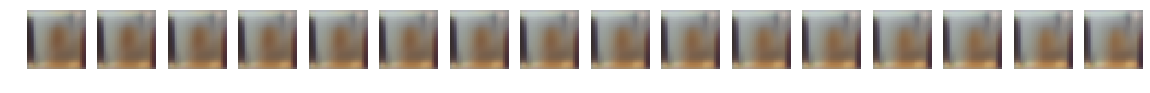

In [27]:
pbs = 16
new_z = pertube(z, 0.1, pbs, 99)
with torch.no_grad():
    vae_out = vae_model.decoder(new_z)
    gan_out = gan_model(new_z).detach()
show_grid(gan_out, pbs)